In [1]:
%matplotlib inline
import os
from subprocess import call

import xarray as xr
import numpy as np
import cftime
import dask

from scipy import signal

from itertools import product

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib as mpl
import  matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cmocean

import geotools as gt
import plottools as pt
import project as P

USER = os.environ['USER']

In [2]:
xr_open_ds = {'chunks' : {'time':1},
              'decode_coords' : False,
              'decode_times' : False}
xr.set_options(enable_cftimeindex=True)

year_range = np.array((249,316))+1699
time = [cftime.DatetimeNoLeap(year, month, 1) for year, month in 
                  product(range(year_range[0], year_range[1]+1), range(1, 13))]
year = [y*1. for y in range(year_range[0],year_range[1]+1)]
ypm = np.array([31,28,31,30,31,30,31,31,30,31,30,31])/365
wgt = xr.DataArray(np.tile(ypm,int(np.diff(year_range)+1)),dims=('time'),coords={'time':time})

np.testing.assert_allclose(wgt.groupby('time.year').sum(),1.)

In [3]:
extent = [120,260,10,65]
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
prj = ccrs.Mercator(central_longitude=np.mean(extent[0:2]),
                    min_latitude=extent[2],
                    max_latitude=extent[3])

In [4]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

dask.config.set({'distributed.dashboard.link':'http://localhost:{port}/status'})

# Lots of arguments to this command are set in ~/.config/dask/jobqueue.yaml
cluster = PBSCluster(queue='regular',
                     cores = 36,
                     processes = 9,
                     memory = '100GB',                     
                     project = 'NCGD0033',
                     walltime = '04:00:00',
                     local_directory=f'/glade/scratch/{USER}/dask-tmp')
client = Client(cluster)

In [5]:
Nnodes = 4
cluster.scale(9*Nnodes)

In [6]:
clobber = False

droot = '/glade/p_old/decpred/CESM-DPLE_POPCICEhindcast'
variables = ['PD','O2','PV','HMXL','HBLT','TEMP','SALT']

file_out = f'{P.dirt}/work.fosi_npac_ann_means.zarr'

if clobber:
    call(['rm','-fr',file_out])

if os.path.exists(file_out):
    ds = xr.open_zarr(file_out,decode_times=False,decode_coords=False)

else:
    dsm = xr.Dataset()
    for v in variables:
        dsm = xr.merge((dsm,xr.open_dataset(f'{droot}/g.e11_LENS.GECOIAF.T62_g16.009.pop.h.{v}.024901-031612.nc',**xr_open_ds)))
    grid_vars = [v for v in dsm.variables if 'time' not in dsm[v].dims]
    dsm.time.values = time
    
    # subset to N Pac
    dsm = dsm.isel(nlat=slice(187,331),nlon=slice(137,276))
    
    # save attrs
    attrs = {v:dsm[v].attrs for v in dsm.variables}
    encoding = {v:dsm[v].encoding for v in dsm.variables}
    
    # groupby.sum() does not seem to handle missing values correctly: yields 0 not nan
    # the groupby.mean() does return nans, so create a mask of valid values for each variable
    valid = {v : dsm[v].groupby('time.year').mean(dim='time').notnull().rename({'year':'time'}) for v in variables}    
   
    # compute the annual means
    ds = (dsm.drop(grid_vars) * wgt).groupby('time.year').sum('time').rename({'year':'time'},inplace=True)
    
    # put the grid variables back
    ds = xr.merge((ds,dsm.drop([v for v in dsm.variables if v not in grid_vars]))) 
    
    # apply the valid-values mask
    for v in variables:
        ds[v] = ds[v].where(valid[v])

    # put the attributes back
    for v in ds.variables:
        ds[v].attrs = attrs[v]

    # put the encoding back
    for v in ds.variables:
        ds[v].encoding = encoding[v]
        
    print(f'writing {file_out}')
    ds.to_zarr(file_out)

ds.PD.values = (ds.PD-1.)*1000.

Compute a regional mean

In [7]:
dsr = P.regional_mean(ds)
dsr = dsr.compute()

Compute the long-term mean and anomaly

In [8]:
dsrm = dsr.sel(time=P.year_range_clim).mean('time')
dsra = dsr - dsrm

What is the relationship between variability in density and O$_2$ in the CalCOFI region?

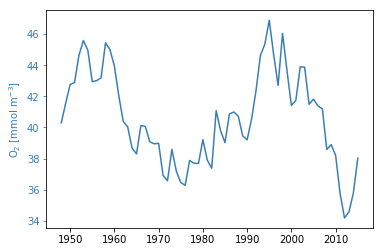

In [9]:
fig = plt.figure()
axL = fig.add_subplot(111)
plt.plot(ds.time,dsr.O2.sel(z_t=slice(200e2,600e2)).mean('z_t'),color='#377eb8')
axL.set_ylabel('O$_2$ [mmol m$^{-3}$]', color='#377eb8')
axL.tick_params('y', colors='#377eb8')
plt.subplots_adjust(right=0.88)
plt.savefig(f'{P.dirf}/CalCOFI-O2-timeseries.pdf')

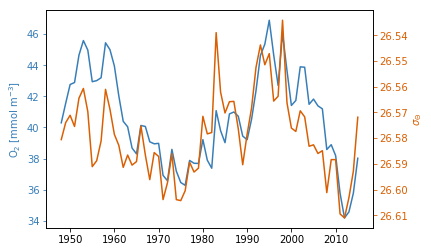

In [10]:
fig = plt.figure()
axL = fig.add_subplot(111)
plt.plot(ds.time,dsr.O2.sel(z_t=slice(200e2,600e2)).mean('z_t'),color='#377eb8')
axL.set_ylabel('O$_2$ [mmol m$^{-3}$]', color='#377eb8')
axL.tick_params('y', colors='#377eb8')

axR = axL.twinx()
plt.plot(ds.time,dsr.PD.sel(z_t=slice(200e2,600e2)).mean('z_t'),color='#d95f02')
axR.set_ylabel('$\sigma_{\Theta}$', color='#d95f02')
axR.tick_params('y', colors='#d95f02')
ylm = axR.get_ylim()
axR.set_ylim(ylm[::-1])
plt.subplots_adjust(right=0.88)
plt.savefig(f'{P.dirf}/CalCOFI-O2-PD-timeseries.pdf')

Over what range does $\sigma_{\theta}$ vary?

In [11]:
sigma_range = np.array([dsr.PD.sel(z_t=slice(200e2,600e2)).mean('z_t').min().values,
               dsr.PD.sel(z_t=slice(200e2,600e2)).mean('z_t').max().values])
sigma_range

array([26.53416836, 26.61102324])

What is the mean density and O$_2$ structure in the region?

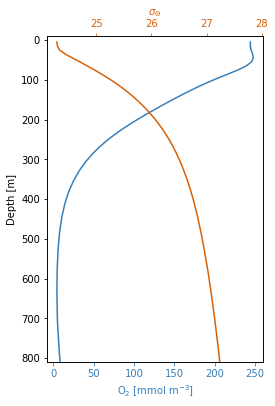

In [12]:
fig = plt.figure(figsize=mpl.rcParams["figure.figsize"][::-1])

axL = fig.add_subplot(111)
plt.plot(dsrm.O2,dsrm.z_t/1e2,color='#377eb8')
axL.set_xlabel('O$_2$ [mmol m$^{-3}$]', color='#377eb8')
axL.tick_params('x', colors='#377eb8')

axL.set_ylim([1000,0])

axR = axL.twiny()
plt.plot(dsrm.PD,dsrm.z_t/1e2,color='#d95f02')
axR.set_xlabel('$\sigma_{\Theta}$', color='#d95f02')
axR.tick_params('x', colors='#d95f02')
axR.set_ylim([810,-10])

axL.set_ylabel('Depth [m]')
plt.subplots_adjust(left=0.15)
plt.savefig(f'{P.dirf}/CalCOFI-mean-O2-PD-profile.pdf')

How does vertical structure determine temporal variation in oxygen?

Attempt to compute the heave effect from finite difference....

In [13]:
dsrmTOP = dsrm.sel(z_t=200e2,method='nearest')
dsrmBOT = dsrm.sel(z_t=800e2,method='nearest')

dXbardz = (dsrmBOT - dsrmTOP) / (dsrmBOT.z_t - dsrmTOP.z_t)

heave_effect = dXbardz.O2 / dXbardz.PD

print(f'dO2dz = {dXbardz.O2.values}')
print(f'drhodz = {dXbardz.PD.values}')
print(f'Heave effect = {heave_effect.values}')

dO2dz = [-0.00166981]
drhodz = [1.97787372e-05]
Heave effect = [-84.42448381]


That's a little clunky... Now let's use a linear regression model built from the mean oxygen verus density profiles

array([-139.69611398, 3745.39748618])

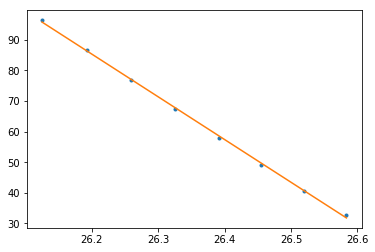

In [14]:
dsrmTC = dsrm.sel(z_t=slice(200e2,800e2))
dsrmTC = dsrmTC.where(dsrmTC.PD<sigma_range[1])

x = dsrmTC.PD.values.squeeze()
y = dsrmTC.O2.values.squeeze()
k = ~np.isnan(x)
x = x[k]
y = y[k]
xrng = np.array([x.min(),x.max()])

plt.plot(dsrmTC.PD,dsrmTC.O2,'.')
beta = np.polyfit(x,y,1)
plt.plot(xrng,xrng*beta[0]+beta[1])

#-- assign the heave effect
heave_effect = beta[0]
beta

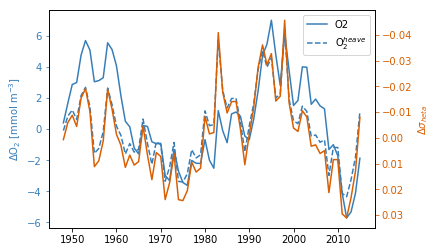

In [19]:
O2heave = dsra.PD.sel(z_t=slice(200e2,600e2)).mean('z_t')*heave_effect

fig = plt.figure()
axL = fig.add_subplot(111)
plt.plot(dsra.time,dsra.O2.sel(z_t=slice(200e2,600e2)).mean('z_t'),color='#377eb8')
plt.plot(dsra.time,O2heave,linestyle='--',color='#377eb8',label='O$_2^{heave}$')
axL.set_ylabel('$\Delta$O$_2$ [mmol m$^{-3}$]', color='#377eb8')
axL.tick_params('y', colors='#377eb8')
plt.legend()
axR = axL.twinx()
plt.plot(dsra.time,dsra.PD.sel(z_t=slice(200e2,600e2)).mean('z_t'),color='#d95f02')
axR.set_ylabel('$\Delta$$\sigma_{\theta}$', color='#d95f02')
axR.tick_params('y', colors='#d95f02')
ylm = axR.get_ylim()
axR.set_ylim(ylm[::-1])
plt.subplots_adjust(right=0.88)

plt.savefig(f'{P.dirf}/CalCOFI-O2-O2heave-PD-timeseries.pdf')

array([-138.70330908, 3727.20734628])

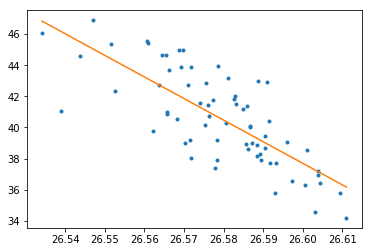

In [157]:
x = dsr.PD.sel(z_t=slice(200e2,600e2)).mean('z_t').values.squeeze()
y =  dsr.O2.sel(z_t=slice(200e2,600e2)).mean('z_t').values.squeeze()

xrng = np.array([x.min(),x.max()])
plt.plot(x,y,'.')
beta = np.polyfit(x,y,1)
plt.plot(xrng,xrng*beta[0]+beta[1])
beta

How much variance is explained by the heave component?

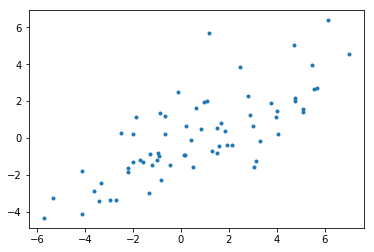

In [17]:
plt.plot(dsra.O2.sel(z_t=slice(200e2,600e2)).mean('z_t'),O2heave,'.')